# (1.1) Load Datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize

In [3]:
from collections import namedtuple
from collections import defaultdict

np.set_printoptions(threshold=np.inf)
Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

# (1.2) Load Embedding Models

In [5]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None), 
              Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None),
              Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None),
              Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

C:\Users\Studio\Anaconda3\lib\site-packages\gensim-3.5.0-py3.6-win-amd64.egg\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


load model : glove.6B.50d.txt
load model : glove.6B.100d.txt
load model : glove.6B.200d.txt
load model : glove.twitter.27B.50d.txt
load model : glove.twitter.27B.100d.txt
load model : glove.twitter.27B.200d.txt
[Model(type='glove', name='glove.6B.50d.txt', dimension=50, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000251C3072B0>), Model(type='glove', name='glove.6B.100d.txt', dimension=100, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000002529CF19B0>), Model(type='glove', name='glove.6B.200d.txt', dimension=200, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000253BD97EB8>), Model(type='glove', name='glove.twitter.27B.50d.txt', dimension=50, corpus='twitter', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000002557711D68>), Model(type='glove', name='glove.twitter.27B.100d.txt', dimension=100, corpus='twitt

In [6]:
models = []
models.extend(glove_models)

# (2.1) Preprocessing
Here we present all the code to preprocess the data stored in a dataframe into a proper representation that can be used in sequence tagging models.

In [7]:
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys
from collections import Counter
from ngram_representation import missing_strat_random
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    '''
    Receives a sentence denoted by context and applies tokenization
    on the input. Each token is annotated with its word index starting
    from 1 and the corresponding start and end character positions of 
    the word. Also applies some strategies to handle unproper formated
    input sentence string such as removing additional whitespaces and 
    quotation marks that otherwise change the actual character start
    and end positions. All results are cached in case it has to be computed
    multiple times for the same sentence.
    '''
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding, dimension, 
                     missing='unique', provided = ['s_target', 'e_target']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a vocabulary of the words contained
    and assigns unique indicies to the words. In particular, it returns 
    a map of indices to their words, a map of words to their indices
    and based on the provided embedding model an embedding matrix
    for the constructed vocabulary. For missing vocabulary, it 
    constructs a random embedding and a proper index is missing parameter
    is set to 'unique', otherwise if it is set to 'equal' it creates
    a random embedding for one special UNK embedding and neglects missing
    vocabulary in the built index. All tokens in the 'provided' list,
    receive under 'equal' mode still individual random embeddings.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_words = [word for sentence in sentences for word in sentence]
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    index = 1
    word2index = {}
    for (word, count) in counter.most_common():
        if (missing=='unique' or word in embedding.vocab):
            word2index[word] = index
            index += 1
    word2index['_pad_'] = 0
    if missing == 'equal':
        word2index['_unk_'] = len(word2index)
        for token in provided:
            word2index[token] = len(word2index)
    index2word = {index : word for word, index in word2index.items()}
    vocab_size = len(word2index)
    print('# Vocab : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_words = []
    for word, index in word2index.items():
        if word in embedding.vocab:
            embedding_matrix[index] = embedding[word]
        else:
            embedding_matrix[index] = missing_strat_random(word, dimension)
            missing_embed_words.append(word)
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return word2index, index2word, embedding_matrix


def build_char_vocabulary(sentences, embedding, dimension, 
                          missing='unique', provided = ['_']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a character vocabulary and provides
    a mapping of unique indices to the found characters, a mapping of
    the characters to their indicies and a character embedding matrix
    where the i-th row represents the character embedding of the character
    with index i. This is based on a provided character embedding, represented
    as a dictionary. Provided tokens will be added as a single char to
    the vocabulary.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_chars = [char for sentence in sentences 
                 for word in sentence for char in word]
    all_chars.extend(provided)
    print('# Chars : {}'.format(len(all_chars)))
    counter = Counter(all_chars)
    index = 1
    char2index = {}
    for (char, count) in counter.most_common():
        if (missing=='unique' or char in embedding.keys()):
            char2index[char] = index
            index += 1
    char2index['_pad_'] = 0
    if missing == 'equal':
        char2index['_unk_'] = len(char2index)
    index2char = {index : char for char, index in char2index.items()}
    vocab_size = len(char2index)
    print('# Vocab (chars) : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_chars = []
    for char, index in char2index.items():
        if char in embedding.keys():
            embedding_matrix[index] = embedding[char]
        else:
            embedding_matrix[index] = missing_strat_random(char, dimension)
            missing_embed_chars.append(char)
    missing_embed_count = len(missing_embed_chars)
    print('# Chars missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return char2index, index2char, embedding_matrix


def compute_character_embeddings(embedding):
    '''
    Computes a character embedding as a dictionary of word to its
    embedding based on a gensim word embedding. For each character,
    averages the word embeddings containing the character as an
    approximation to character-level embeddings.
    '''
    chars = {}
    for word, vocab in embedding.vocab.items():
        vector = embedding[word]
        for char in word:
            if ord(char)<128:
                if char in chars:
                    chars[char] = (chars[char][0]+vector, 
                                   chars[char][1]+1)
                else:
                    chars[char] = (vector, 1)
    for char, (vector, num) in chars.items():
        chars[char] = np.round(vector/num, 6).tolist()
    return chars

def forward_transformation_v1(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    '''
    Transforms the provided dataframe rows into a representation
    to be used in a sequence classifier. For each sentence in the
    dataset, returns the sentence id, the sentence as a list of 
    words based on tokenization, the binary label for each word, 
    the probability label for each word and a list of (start, end)
    tuples representing the start and end positions of the words 
    in the sentence word list. This can be used to map back the
    predictions later. This function should be used if classification
    is done on word level.
    '''
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['target'], 
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentence_ids = []
    sentences = []
    binaries = []
    probabilities = []
    start_ends = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentence_ids.append(sent_id)
        sentences.append([vals[0] for vals in sent_repr])
        binaries.append([vals[3] for vals in sent_repr])
        probabilities.append([vals[4] for vals in sent_repr])
        start_ends.append([(vals[1], vals[2]) for vals in sent_repr])
    return sentence_ids, sentences, start_ends, binaries, probabilities


def forward_transformation_v2(dataframe, start_tag = 's_target', end_tag = 'e_target',
                                   lowercase = True, filter_punc = True, filtering = "a132"):
    '''
    Transforms the provided dataframe rows into a representation
    to be used in a sequence classifier. Here, each row in the dataframe
    is transformed into one instance to classify and each target in a 
    sentence is tagged by surrounding it with the provided start and
    end tag. Hence, the whole sequence is classified at once. Returns
    the transformed sentences (one for each row in the dataframe), the
    corresponding binary and probabilitiy label.
    '''
    sentences = []
    binaries = []
    probabilities = []
    for index, row in dataframe.iterrows():
        sentence = row['sentence']
        start = row['start']
        end = row['end']
        sentence = sentence[:start] + start_tag + ' ' + sentence[start:end] + \
                             ' ' + end_tag + sentence[end:]
        if lowercase:
            sentence = sentence.lower()
        sent_repr = all_tokens_with_index(sentence)
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append([word for word, index, start, end in sent_repr])
        binaries.append(row['binary'])
        probabilities.append(row['prob'])
    return sentences, binaries, probabilities


def merge_train_test_dataset(dataset):
    '''
    Computes the training and test set size as (1) the
    number of rows and (2) the number of unique sentences
    contained. Merges the training and test set and
    computes the same values for the merged dataframe.
    This can be used before creating the vocabulary,
    to also not miss vocabulary contained solely in the
    test set. Before training, the dataset has to be split
    up again based on the provided numbers.
    '''
    # Compute num rows and sents for train and test
    train_num_rows = dataset.train.shape[0]
    train_num_sents = len(list(set(dataset.train.sentence.values.tolist())))
    test_num_rows = dataset.test.shape[0]
    test_num_sents = len(list(set(dataset.test.sentence.values.tolist())))
    # Merge dataframes and compute same values
    dataset_merged = dataset.train.append(dataset.test)
    dataset_merged['sent_id'] = dataset_merged.groupby('sentence').ngroup()
    dataset_num_rows = dataset_merged.shape[0]
    dataset_num_sents = len(list(set(dataset_merged.sentence.values.tolist())))
    print('----------------------')
    print('# Rows train : {}'.format(train_num_rows))
    print('# Rows test : {}'.format(test_num_rows))
    print('# Rows dataset : {}'.format(dataset_num_rows))
    print('----------------------')
    print('# Sents train : {}'.format(train_num_sents))
    print('# Sents test : {}'.format(test_num_sents))
    print('# Sents dataset : {}'.format(dataset_num_sents))
    print('----------------------')
    return dataset_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents
        
def split_train_test_dataset(dataset, index):
    '''
    Splits the given dataset (here the list of sentences represented
    as list of words, binary label lists etc.) into train and test
    based on the given index. Depending on the used sequence representation
    (v1 or v2), the index should be either the number of training sentences 
    (unique) or the number of training rows.
    '''
    train = dataset[:index]
    test = dataset[index:]
    print('Training set length : {}'.format(len(train)))
    print('Test set length : {}'.format(len(test)))
    return train, test
        
def sentence_max_length(sentences):
    sent_lens = [len(sentence) for sentence in sentences]
    sent_max_length = np.max(sent_lens)
    print('Max length sentence : {}'.format(sent_max_length))
    return sent_max_length

def pad_encode_sequences(sentences, word2index, missing, max_length):
    '''
    Encodes a list of sentences (a sentence represented as a list of words)
    into their corresponding integer index based on the provided dictionary.
    For missing tokens in the dictionary, applies the provided 'missing' value.
    Afterwards, applies padding to the sentences and uses 'max_length' as the
    maximum overall sentence length.
    '''
    words_with_indices = [[word2index.get(word, missing)
                        for word in sent] for sent in sentences]
    pad_val = word2index['_pad_']
    return pad_sequences(maxlen=max_length, \
            sequences=words_with_indices, padding="post", value=pad_val)

def pad_binaries_probs(binaries, probabilities, max_length):
    '''
    Applies padding to binary labels and the probabilities.
    Parameter 'max_length' is used as the maximum length
    to pad the two provided lists to.
    '''
    binary_padded = pad_sequences(maxlen=max_length, sequences=binaries, padding="post", value=0)
    prob_padded = pad_sequences(maxlen=max_length, sequences=probabilities, padding="post", value=0, dtype="float")
    return binary_padded, prob_padded

def pad_chars(sentences, char2index, sent_max_length, char_max_length):
    words_as_chars_indices = []
    for sent in sentences:
        sent_repr = []
        for sent_index in range(sent_max_length):
            words_repr = []
            for word_index in range(char_max_length):
                try:
                    words_repr.append(char2index[sent[sent_index][word_index]])
                except:
                    words_repr.append(char2index.get('_pad_'))
            sent_repr.append(words_repr)
        words_as_chars_indices.append(sent_repr)
    return words_as_chars_indices

def ngram_prediction_agg_majority_vote(predictions):
    positive_sum = np.sum(predictions)
    ratio = positive_sum / len(predictions)
    return int(ratio + 0.5)

def ngram_prediction_agg_max(predictions):
    return np.max(predictions)

def ngram_prediction_agg_begin(predictions):
    return predictions[0]

def ngram_prediction_agg_end(predictions):
    return predictions[-1]

def backward_transformation_v1(dataset, sent_ids, test_words_padded, 
                    index2word, test_start_end, final_predictions):
    '''
    Based on the dataset, the list of sentence_ids, the padded words
    from the test set, the start and end tuple list of the test set and
    the produced v1 predictions, maps the predictions back to original
    representation (from number of sentences to number of rows) and
    computes the F1-score between predictions and labels of the orignal
    representation. For n-gram targets, applies an aggregation strategy.
    '''
    ngram_prediction_agg = ngram_prediction_agg_max
    results = []
    num_missing_match = []
    all_predictions = []
    all_labels = []
    count=0
    sent_count = 0
    for ind, sent in enumerate(test_words_padded):
        sent_id = sent_ids[ind]
        ses = test_start_end[ind]
        preds = final_predictions[ind]
        selected = dataset.loc[dataset.sent_id==sent_id,]
        targets = selected.target.values.tolist()
        start_ends = list(zip(selected.start.values.tolist(), selected.end.values.tolist()))
        binary_y = selected.binary.values.tolist()
        for label_index, (start, end) in enumerate(start_ends):
            matching_indices = [i for i, (s, e) in enumerate(ses) if overlaps(start, end, s, e)]
            if not matching_indices:
                num_missing_match.append((sent_id, (start,end), ses, sent))
                prediction = 1
            matching_predictions = [preds[i] for i in matching_indices]
            if len(matching_predictions)>1:
                prediction = ngram_prediction_agg(matching_predictions)
            else:
                if matching_indices:
                    prediction = matching_predictions[0]
            matching_labels = binary_y[label_index]
            all_labels.append(matching_labels)
            all_predictions.append(prediction)
    f1 = f1_score(all_labels, all_predictions)
    return f1

# (2.2) DL Models

## (2.2.1) Utility Methods

In [8]:
from sklearn.metrics import f1_score
import keras.callbacks

class MetricsV2(keras.callbacks.Callback):
    def __init__(self, training_data, show_test_data=True):
        self.train_f1_scores = []
        self.test_f1_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        test_predict = np.argmax(test_predict, axis = 1)
        test_f1 = f1_score(test_label, test_predict)
        self.test_f1_scores.append(test_f1)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = np.argmax(train_predict, axis = 1)
        train_f1 = f1_score(train_label, train_predict)
        self.train_f1_scores.append(train_f1)
        print('Training F1-score : {}'.format(train_f1))
        print('Testing F1-score : {}'.format(test_f1))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
    
class MetricsV1(keras.callbacks.Callback):
    
    def __init__(self, training_data, show_test_data=True):
        self.train_f1_scores = []
        self.test_f1_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        test_label = test_label.reshape((test_shape[0]*test_shape[1], test_shape[2]))
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]), test_shape[2])
        test_predict = np.argmax(test_predict, axis = 1)
        test_f1 = f1_score(test_label, test_predict)
        self.test_f1_scores.append(test_f1)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1], train_shape[2]))
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]), train_shape[2])
        train_predict = np.argmax(train_predict, axis = 1)
        train_f1 = f1_score(train_label, train_predict)
        self.train_f1_scores.append(train_f1)
        print('Training F1-score : {}'.format(train_f1))
        print('Testing F1-score : {}'.format(test_f1))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
            
class MetricsV1Char(keras.callbacks.Callback):
    
    def __init__(self, training_data, show_test_data=True):
        self.train_f1_scores = []
        self.test_f1_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[2]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        test_label = test_label.reshape((test_shape[0]*test_shape[1], test_shape[2]))
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict([self.validation_data[0], self.validation_data[1]]))
        print(test_predict.shape)
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]), test_shape[2])
        test_predict = np.argmax(test_predict, axis = 1)
        test_f1 = f1_score(test_label, test_predict)
        self.test_f1_scores.append(test_f1)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1], train_shape[2]))
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]), train_shape[2])
        train_predict = np.argmax(train_predict, axis = 1)
        train_f1 = f1_score(train_label, train_predict)
        self.train_f1_scores.append(train_f1)
        print('Training F1-score : {}'.format(train_f1))
        print('Testing F1-score : {}'.format(test_f1))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
            

class MetricsElmoV1(keras.callbacks.Callback):
    '''
    Make sure to use 'sparse_categorical_crossentropy' as the loss function.
    '''
    
    def __init__(self, training_data, batch_size, show_test_data=True):
        self.train_f1_scores = []
        self.test_f1_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        print(test_label.shape)
        test_label = test_label.reshape((test_shape[0]*test_shape[1]))
        test_predict = prediction_elmo_model(self.validation_data[0], self.model, self.batch_size)
        print(test_predict.shape)
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]))
        test_f1 = f1_score(test_label, test_predict)
        self.test_f1_scores.append(test_f1)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1]))
        train_predict = prediction_elmo_model(self.training_data[0], self.model, self.batch_size)
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]))
        train_f1 = f1_score(train_label, train_predict)
        self.train_f1_scores.append(train_f1)
        print('Training F1-score : {}'.format(train_f1))
        print('Testing F1-score : {}'.format(test_f1))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)

In [9]:
def prediction_elmo_model(data, model, batch_size):
    '''
    Returns the predictions of an ELMo Keras model for the
    provided data and batch_size. If required, extends the
    data to make it divisible by batch_size in order to
    work with the ELMo model and cuts of the extension.
    Creates predictions iteratively for batch_size large
    fractions of the provided data.
    '''
    data = np.array(data.copy())
    # Ensure that the data has number of samples
    # which is divisible by the batch size
    add_index = (batch_size - (data.shape[0] % batch_size))
    data_ext = np.concatenate((data, data[:add_index]))
    # Get the predictions of the elmo model on the 
    # extended data
    predictions = None
    print(data_ext.shape)
    num_samples = data_ext.shape[0]
    for index in range(0, int((num_samples/batch_size))):
        print((index*batch_size),((index+1)*batch_size))
        test_words_batch = data_ext[(index*batch_size):((index+1)*batch_size)]
        prediction = model.predict(test_words_batch)
        final_prediction = np.argmax(prediction, axis = -1)
        if predictions is None:
            predictions = final_prediction
        else:
            predictions = np.concatenate((predictions, final_prediction))
    return predictions[:data.shape[0]]

In [10]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

## (2.2.2) Models

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

INFO:tensorflow:Using C:\Users\Studio\AppData\Local\Temp\tfhub_modules to cache modules.


In [12]:
# Best model dataset[0] elmo batch=2 epoch=1 f1=0.7632978723404255

In [215]:
f1

0.7632978723404255

In [40]:
from keras.models import Model, Input
from keras.layers.merge import add, concatenate
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, \
        Bidirectional, Lambda, average, SpatialDropout1D, Reshape, Flatten, Conv2D, MaxPooling2D, Conv1D, GlobalMaxPooling1D
from attention_keras import AttentionLayer
from keras_contrib.layers import CRF

def model_v1_LSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = LSTM(units=150, return_sequences=True, recurrent_dropout=0.1)(drop)
    output = TimeDistributed(Dense(2, activation="softmax"))(lstm)
    return Model(in_seq, output)

def model_v1_BiLSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.1))(drop)
    output = TimeDistributed(Dense(2, activation="softmax"))(lstm)
    return Model(in_seq, output)

def model_v1_char_BiLSTM(sent_max_length, char_max_length, word_embedding, char_embedding):
    # (1.1) Word input parameters
    word_vocab_size = word_embedding.shape[0]
    word_dimension = word_embedding.shape[1]
    # (1.2) Word embedding layers
    word_in = Input(shape=(sent_max_length,))
    word_embed = Embedding(input_dim=word_vocab_size, output_dim=word_dimension, \
                      weights=[word_embedding], input_length=sent_max_length)(word_in)
    # (2.1) Char input parameters
    char_vocab_size = char_embedding.shape[0]
    char_dimension = char_embedding.shape[1]
    # (2.2) Char embedding layers
    char_in = Input(shape=(sent_max_length, char_max_length))
    char_embed = TimeDistributed(Embedding(input_dim=char_vocab_size, output_dim=char_dimension, \
                        weights=[char_embedding], input_length=char_max_length, mask_zero=True))(char_in)
    char_lstm = TimeDistributed(Bidirectional(LSTM(units=25, return_sequences=False, recurrent_dropout=0.1)))(char_embed)
    concatenation = concatenate([word_embed, char_lstm], name='c')
    drop1 = SpatialDropout1D(0.3)(concatenation)
    lstm = Bidirectional(LSTM(units=40, return_sequences=True, recurrent_dropout=0.1))(drop1)
    drop2 = SpatialDropout1D(0.3)(lstm)
    out = TimeDistributed(Dense(2, activation="softmax"))(drop2) 
    return Model([word_in, char_in], out)


def model_v1_ElMo_residual_BiLSTM(sent_max_length, batch_size):
    def ElmoEmbedding(x):
        return elmo_model(inputs={
                                "tokens": tf.squeeze(tf.cast(x, tf.string)),
                                "sequence_len": tf.constant(batch_size*[sent_max_length])
                          },
                          signature="tokens",
                          as_dict=True)["elmo"]
    in_seq = Input(shape=(sent_max_length,), dtype=tf.string)
    embed = Lambda(ElmoEmbedding, output_shape=(sent_max_length, 1024))(in_seq)
    lstm_1 = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(embed)
    lstm_2 = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(lstm_1)
    lstm_1 = add([lstm_1, lstm_2])
    out = TimeDistributed(Dense(2, activation="softmax"))(lstm_1)
    return Model(in_seq, out)

def model_v1_BiLSTM_CRF(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.1))(drop)
    dense = Dense(30, activation="relu")(lstm)
    crf = CRF(2, learn_mode='marginal')
    output = crf(dense)
    return Model(in_seq, output)

def model_v2_LSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = LSTM(units=150, return_sequences=False, recurrent_dropout=0.1)(drop)
    output = Dense(2, activation="softmax")(lstm)
    return Model(in_seq, output)

def model_v2_BiLSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=20, return_sequences=False, recurrent_dropout=0.1))(drop)
    output = Dense(2, activation="softmax")(lstm)
    return Model(in_seq, output)

def model_v2_attention_BiLSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.1))(drop)
    attended = AttentionLayer(name='attention')(lstm)
    output = Dense(2, activation="softmax")(attended)
    return Model(in_seq, output)

def model_v2_simple_CNN(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    embed_reshaped = Reshape((sent_max_length, dimension, 1))(embed)
    conv2d = Conv2D(100, (5, dimension), activation='relu')(embed_reshaped)
    max2d = MaxPooling2D((sent_max_length - 5 + 1, 1))(conv2d)
    flatten = Flatten()(max2d)
    drop = Dropout(0.5)(flatten)
    out = Dense(2, activation='softmax')(drop)
    return Model(in_seq, out)

def model_v2_adv_CNN(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                      weights=[embedding], input_length=sent_max_length)(in_seq)
    embed_reshaped = Reshape((sent_max_length, dimension, 1))(embed)
    # First convolution and pooling layer
    conv_1 = Conv1D(100, 5, activation='relu')(embed)
    pool_1 = GlobalMaxPooling1D()(conv_1)
    #pool_1 = MaxPooling2D((sent_max_length - 5 + 1, 1))(conv_1)
    # Second convolution and pooling layer
    conv_2 = Conv1D(100, 4, activation='relu')(embed)
    pool_2 = GlobalMaxPooling1D()(conv_2)
    #pool_2 = MaxPooling2D((sent_max_length - 4 + 1, 1))(conv_2)
    # Third convolution and pooling layer
    conv_3 = Conv1D(100, 3, activation='relu')(embed)
    pool_3 = GlobalMaxPooling1D()(conv_3)
    #pool_3 = MaxPooling2D((sent_max_length - 3 + 1, 1))(conv_3)
    # Concatenate all three layers
    concat = concatenate([pool_1, pool_2, pool_3])
    # Flatten concatenation
    #flatten = Flatten()(concat)
    drop = Dropout(0.5)(concat)
    out = Dense(2, activation='softmax')(drop)
    return Model(in_seq, out)

## (2.2.3) Models preparation

In [25]:
model = None

In [27]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

In [34]:
from keras import optimizers

def preparation_v1(dataset, embedding, model_func):
    '''
    Provides wrapping of preprocessing and postprocessing
    for the first variant of sequence classification v1 
    (where complexity of each word is predicted individually)
    based on the provided dataset, embedding and model_func.
    The model_func is a function that should accept values
    specifying the embedding layer (max_sentence_length, 
    vocab_dimension, embedding_weights) and return the 
    constructed Keras model instance. Returns the final test 
    F1-score, F1-scores of training and F1-scores
    of test sets for each epoch.
    '''
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
        binaries, probabilties = forward_transformation_v1(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                embedding, embedding.vector_size, missing='unique')
    # Pad the sentences and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    binaries_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries_padded]
    # Instantiate the model
    model = model_func(sent_max_length, len(word2index), embedding.vector_size, word_embedding)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_binaries_padded_cat, test_binaries_padded_cat = split_train_test_dataset(\
                    binaries_padded_categorical, train_num_sents)
    print(len(train_words_padded))
    print(len(test_words_padded))
    # Fit the model with a custom metric to obtain the F1-scores
    metrics_v1 = MetricsV1((train_words_padded, np.array(train_binaries_padded_cat)))
    history = model.fit(train_words_padded, np.array(train_binaries_padded_cat),
                    batch_size=1, epochs=10, validation_data = (test_words_padded, 
                    np.array(test_binaries_padded_cat)), verbose=1, callbacks=[metrics_v1])
    # Use trained model to predict the test set
    predictions = model.predict(test_words_padded)
    final_predictions = np.argmax(predictions, axis = 2)
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                    test_words_padded, index2word, test_ses, final_predictions)
    return f1, metrics_v1.train_f1_scores, metrics_v1.test_f1_scores


def preparation_char_v1(dataset, w_embedding, c_embedding):
    '''
    Provides wrapping of preprocessing and postprocessing
    for the first variant of sequence classification v1 
    (where complexity of each word is predicted individually)
    based on the provided dataset, embedding and model_func.
    The model_func is a function that should accept values
    specifying the embedding layer (max_sentence_length, 
    vocab_dimension, embedding_weights) and return the 
    constructed Keras model instance. Returns the final test 
    F1-score, F1-scores of training and F1-scores
    of test sets for each epoch.
    '''
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
        binaries, probabilties = forward_transformation_v1(dataframe_merged, lowercase=False)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                w_embedding, w_embedding.vector_size, missing='unique')
    char_dimension = len(list(c_embedding.values())[0])
    char2index, index2char, char_embedding = build_char_vocabulary(sentences, \
                                c_embedding, char_dimension, missing='unique')
    # Pad the sentences and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    binaries_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries_padded]
    # Pad char sequences
    char_max_length = 11
    chars_padded = pad_chars(sentences, char2index, sent_max_length, char_max_length)
    # Instantiate the model
    model = model_v1_char_BiLSTM(sent_max_length, char_max_length, word_embedding, char_embedding)
    adam = optimizers.Adam(clipnorm=1.)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_chars_padded, test_chars_padded = split_train_test_dataset(chars_padded, train_num_sents)
    train_chars_reshaped = np.array(train_chars_padded).reshape(len(train_chars_padded), \
                                    sent_max_length, char_max_length)
    test_chars_reshaped = np.array(test_chars_padded).reshape(len(test_chars_padded), \
                                    sent_max_length, char_max_length)
    train_binaries_padded_cat, test_binaries_padded_cat = split_train_test_dataset(\
                    binaries_padded_categorical, train_num_sents)
    print(len(train_words_padded))
    print(len(test_words_padded))
    # Fit the model with a custom metric to obtain the F1-scores
    metrics_v1 = MetricsV1Char(([train_words_padded, train_chars_reshaped], np.array(train_binaries_padded_cat)))
    history = model.fit([train_words_padded, train_chars_reshaped], np.array(train_binaries_padded_cat),
                    batch_size=1, epochs=3, validation_data = ([test_words_padded, test_chars_reshaped], 
                    np.array(test_binaries_padded_cat)), verbose=1, callbacks=[metrics_v1])
    # Use trained model to predict the test set
    predictions = model.predict([test_words_padded, test_chars_reshaped])
    final_predictions = np.argmax(predictions, axis = -1)
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                     test_words_padded, index2word, test_ses, final_predictions)
    return f1, metrics_v1.train_f1_scores, metrics_v1.test_f1_scores, final_predictions


def preparation_elmo_v1(dataset, embedding):
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
            binaries, probabilties = forward_transformation_v1(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                    embedding, embedding.vector_size, missing='unique')
    # Pad the sentences (for elmo we need the actual words, so we
    # first map it to integers, pad the integer sequence and map 
    #it back to string) and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    words_padded = [[index2word[index] for index in sentence] for sentence in words_padded]
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    # We use sparse_categorical_crossentropy so we not require the
    # binaries mapped to categorical representation, but we reshape them
    train_binaries_padded, test_binaries_padded = split_train_test_dataset(binaries_padded, train_num_sents)
    train_binaries_padded = train_binaries_padded.reshape((train_binaries_padded.shape[0], \
                                                              train_binaries_padded.shape[1], 1))
    test_binaries_padded = test_binaries_padded.reshape((test_binaries_padded.shape[0], \
                                                              test_binaries_padded.shape[1], 1))
    # Make sure the training sample size is divisible by the batch size
    batch_size = 2
    training_cutoff = 386
    train_words_padded = train_words_padded[:training_cutoff]
    train_binaries_padded = train_binaries_padded[:training_cutoff]
    # Make sure the test sample size is divisible by the batch size
    test_cutoff = 52
    test_words_padded = test_words_padded[:test_cutoff]
    test_binaries_padded = test_binaries_padded[:test_cutoff]
    print(np.array(train_binaries_padded).shape)
    print(np.array(test_binaries_padded).shape)
    # Fit the model with a custom metric to obtain the F1-scores
    model = model_v1_ElMo_residual_BiLSTM(sent_max_length, batch_size)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    # Use custom ELMo metric to evaluate F1-score after each epoch
    metrics_elmo_v1 = MetricsElmoV1((np.array(train_words_padded), \
                                     np.array(train_binaries_padded)), batch_size)
    history = model.fit(np.array(train_words_padded), np.array(train_binaries_padded),
                         batch_size=batch_size, epochs=2, validation_data = (np.array(test_words_padded), 
                        np.array(test_binaries_padded)), verbose=1, callbacks=[metrics_elmo_v1])
    # Use trained model to predict the test set
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_binaries_padded, test_binaries_padded = split_train_test_dataset(binaries_padded, train_num_sents)
    prediction = prediction_elmo_model(test_words_padded, model, batch_size)
    test_words_padded = test_words_padded[:53]
    preds = prediction[:53]
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                    test_words_padded, index2word, test_ses, preds)
    return f1, metrics_elmo_v1.train_f1_scores, metrics_elmo_v1.test_f1_scores



   
def preparation_v2(dataset, embedding, model_func):
    '''
    Provides wrapping of preprocessing and postprocessing
    for the second variant of sequence classification v1 
    (where a target is marked in the sentence and the overall
    sentence is classified) based on the provided dataset,
    embedding and model_func.The model_func is a function 
    that should accept values specifying the embedding layer
    (max_sentenc_length, vocab_dimension, embedding_weights) 
    and return the constructed Keras model instance. Returns
    the final test F1-score, F1-scores of training and F1-scores
    of test sets for each epoch.
    '''
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation where each target is marked in its sentence
    sentences, binaries, probabilties = forward_transformation_v2(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                            embedding, embedding.vector_size, missing='unique')
    # Pad the sentences and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries]
    # Instantiate the model
    model = model_func(sent_max_length, len(word2index), embedding.vector_size, word_embedding)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_rows)
    train_binaries_categorical, test_binaries_categorical = split_train_test_dataset(binaries_categorical, train_num_rows)
    # Fit the model with a custom metric to obtain the F1-scores
    metrics_v2 = MetricsV2((train_words_padded, np.array(train_binaries_categorical)))
    history = model.fit(train_words_padded, np.array(train_binaries_categorical),
                    batch_size=1, epochs=10, validation_data = (test_words_padded, 
                    np.array(test_binaries_categorical)), verbose=1, callbacks=[metrics_v2])
    print(len(train_words_padded))
    print(len(test_words_padded))
    # Use trained model to predict the test set
    predictions = model.predict(test_words_padded)
    final_predictions = np.argmax(predictions, axis = 1)
    targets = np.argmax(test_binaries_categorical, axis = 1)
    f1 = f1_score(targets, final_predictions)
    return f1, metrics_v2.train_f1_scores, metrics_v2.test_f1_scores

In [34]:
f1, train_f1s, test_f1s, prediction = preparation_v2(datasets[0], \
                    models[2].model, model_v2_adv_CNN)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 186472
# Vocab : 3641
# Words missing embedding : 162
Embedding shape : (3641, 200)
Max length sentence : 103
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 103)          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 103, 200)     728200      input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 99, 100)      100100      embedding_15[0][0]              

KeyboardInterrupt: 

In [33]:
model = preparation_v1(datasets[0], \
                    models[2].model, model_v1_char_BiLSTM)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 200)
Max length sentence : 101


AttributeError: 'int' object has no attribute 'shape'

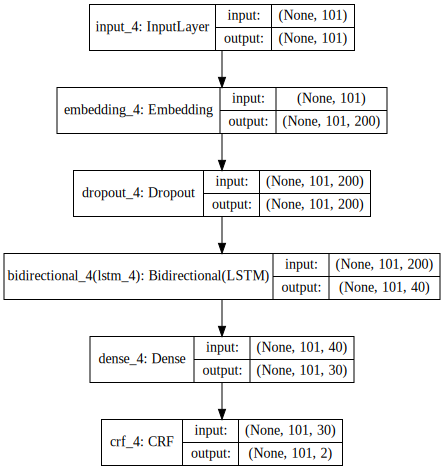

In [32]:
plot_keras_model(model)

In [41]:
model = preparation_char_v1(datasets[0], \
                    models[0].model, compute_character_embeddings(models[0].model))

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3896
# Words missing embedding : 1298
Embedding shape : (3896, 50)
# Chars : 52647
# Vocab (chars) : 118
# Chars missing embedding : 72
Embedding shape : (118, 50)
Max length sentence : 101
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 101, 11)      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 101)          0                                            
__________________________________________________________________________________________________
t

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.pdf', show_shapes=True, show_layer_names=True)

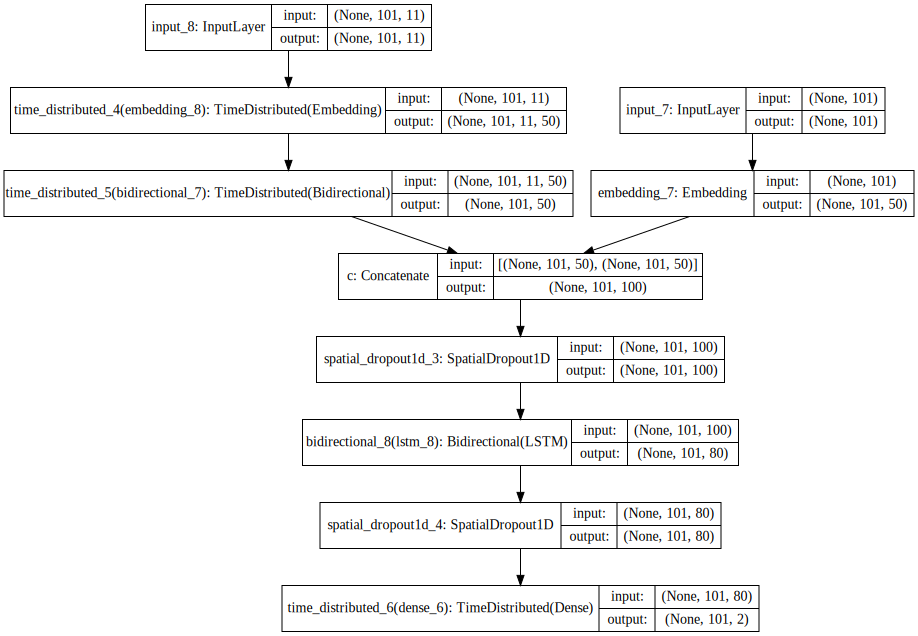

In [42]:
plot_keras_model(model)

In [26]:
f1, train_f1s, test_f1s = preparation_elmo_v1(datasets[0], models[0].model)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
(386, 101, 1)
(52, 101, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 101)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 1024)    0           input_11[0][0]        

KeyboardInterrupt: 

In [131]:
f1

0.738095238095238

In [91]:
f1, train_f1s, test_f1s = preparation_elmo_v1(datasets[0], models[0].model)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
(386, 101, 1)
(52, 101, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 101)          0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 101, 1024)    0           input_32[0][0]        

386/386 [==============================] - 3801s 10s/step - loss: 0.0641 - acc: 0.9700 - val_loss: 0.0586 - val_acc: 0.9754
(52, 101, 1)
(54, 101)
0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
(52, 101)
(388, 101)
0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
54 56
56 58
58 60
60 62
62 64
64 66
66 68
68 70
70 72
72 74
74 76
76 78
78 80
80 82
82 84
84 86
86 88
88 90
90 92
92 94
94 96
96 98
98 100
100 102
102 104
104 106
106 108
108 110
110 112
112 114
114 116
116 118
118 120
120 122
122 124
124 126
126 128
128 130
130 132
132 134
134 136
136 138
138 140
140 142
142 144
144 146
146 148
148 150
150 152
152 154
154 156
156 158
158 160
160 162
162 164
164 166
166 168
168 170
170 172
172 174
174 176
176 178
178 180
180 182
182 184
184 186
186 188
188 190
190 192
192 194
194 196
196

2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53


In [94]:
f1

0.7644444444444445

In [92]:
train_f1s

[0.5056751467710372, 0.7671852899575672]

In [93]:
test_f1s

[0.46537396121883656, 0.7445544554455444]

In [206]:
epochs = []
datatype = []
f1_scores = []
epochs = [epoch for epoch, f1 in enumerate(train_f1s, 1)]
epochs.extend(epochs)
datatype = ['train' for elem in train_f1s]
datatype.extend(['test' for elem in test_f1s])
f1_scores.extend(train_f1s.copy())
f1_scores.extend(test_f1s.copy())
evaluation = [{'F1-score' : result[0], 'epoch' : result[1],
                    'data' : result[2]} for result in zip(f1_scores, epochs, datatype)]
epochs_f1_scores = pd.DataFrame.from_records(evaluation)

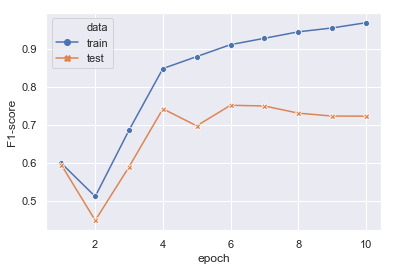

In [207]:
import seaborn as sns
sns.set()
ax = sns.lineplot(x="epoch", y="F1-score",
                   hue="data", style="data",
                   markers=True, dashes=False, data=epochs_f1_scores)
plt.show()

In [ ]:
sentence_lens = [len(sent) for sent in sentences]

Sentence lengths


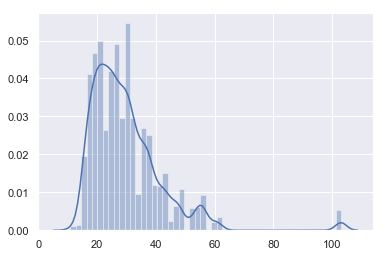

In [105]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
ax = sns.distplot(sentence_lens)
print('Sentence lengths')
plt.show()

In [453]:
figure = ax.get_figure()
figure.savefig('../plots/dl/sentence_length_dist.pdf')

In [196]:
len(metrics.f1_scores)

2

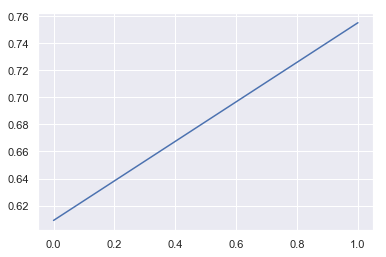

In [197]:
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()